In [1]:
# Adapted from https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Rather than Torch, for example

import keras
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, BatchNormalization
from keras import initializers
from keras.models import Model, Sequential
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import keras.backend as K
import random
import scipy
from scipy.stats import norm
from scipy.stats import multivariate_normal
import sklearn
from sklearn import model_selection
import tensorflow as tf

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Reading in the Data

In [32]:
# Read in the data, make sure it's numeric
X = pd.read_csv("../aline_imputed.csv")
#X = X.iloc[:,4:]  # We don't include the patient, hospital, or ICU stay ID's because they're meaningless in this context

In [33]:
outcome_vars = X.columns[65:]
outcome_vars

Index(['icu_los_day', 'hospital_los_day', 'hosp_exp_flag', 'icu_exp_flag',
       'day_28_flag', 'chf_flag', 'afib_flag', 'renal_flag', 'liver_flag',
       'copd_flag', 'cad_flag', 'stroke_flag', 'malignancy_flag',
       'respfail_flag', 'endocarditis_flag', 'ards_flag', 'pneumonia_flag'],
      dtype='object')

### Splitting into a train/test fold

In [35]:
# Set the train/test size
#X_model_input = X.drop(outcome_vars, axis=1)
X_train, X_test = sklearn.model_selection.train_test_split(X, train_size=0.8)
Y_train, Y_test = X_train[outcome_vars], X_test[outcome_vars]
X_train, X_test = X_train.drop(list(outcome_vars), axis=1), X_test.drop(list(outcome_vars), axis=1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [36]:

# Convert your inputs to numpy arrays (Keras doesn't play nice with pandas dataframes)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [42]:
X_train.shape

(41899, 65)

### Training a decoder, generator and decoder+generator VAE on the dataset

In [43]:
def evaluate_vae_model(X_train, X_test, latent_dimensions, intermediate_dimensions, n_epochs = 20):
    
    #Hyperparameters of interest
    intermediate_dim = intermediate_dimensions
    latent_dim = latent_dimensions
    
    # Other hyperparameters
    original_dim = X_test.shape[1]  # Calculated automatically
    batch_size = 1000  # This might affect the learning rate, but shouldn't affect the overall model outcome
    #n_epochs Not as important when we use the early stopping method (as we do in this method)
    epsilon_std = 1.0  # This shouldn't significantly change the model performance, as the z_log_sigma will adjust to accommodate
    
    # The Encoder, from the original data to the latent dimensions
    inputs = Input(shape=(original_dim,))
    hidden = Dense(intermediate_dim, activation='relu', kernel_initializer=initializers.he_normal(seed=None))(inputs)
    bn = BatchNormalization()(hidden)
    z_mean = Dense(latent_dim, activation='linear', kernel_initializer=initializers.he_normal(seed=None))(bn)
    z_log_sigma = Dense(latent_dim, activation='linear', kernel_initializer=initializers.Zeros())(bn)
    
    # The sampler
    def sample_z(args):
        z_mean, z_log_sigma = args
        eps = K.random_normal(shape=(K.shape(inputs)[0], latent_dim),
                             mean=0., stddev=1.)
        return z_mean + K.exp(z_log_sigma / 2) * eps  # Element-wise product of SD with gaussian noise, + mean vector

    z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # The Decoder
    decoder_h = Dense(intermediate_dim, activation='relu', kernel_initializer=initializers.he_normal(seed=None))  # We don't specify the inputs because we'll use...
    decoder_bn = BatchNormalization()
    decoder_mean = Dense(original_dim, activation='linear', kernel_initializer=initializers.he_normal(seed=None))  # ...the same layers again for the generator model below
    decoder_log_sigma = Dense(original_dim, activation='linear', kernel_initializer=initializers.Zeros())
    h_decoded = decoder_h(z)
    bn_decoded = decoder_bn(h_decoded)
    output_decoded_mean = decoder_mean(bn_decoded)  # Our output is a mean vector (point estimate) and...
    output_decoded_log_sigma = decoder_log_sigma(bn_decoded)  # ...a log_sigma, or log_variance vector...
                                                            # which quantifies our certainty about the point estimate
        
    # The end-to-end autoencoder
    vae = Model(inputs, output_decoded_mean)

    # An encoder, from inputs to the latent space
    encoder = Model(inputs, z_mean)

    # A generator, from the latent space to the reconstructed inputs
    generator_input = Input(shape=(latent_dim,))
    generator_h_decoded = decoder_h(generator_input)
    generator_bn_decoded = decoder_bn(generator_h_decoded)
    generator_output_decoded_mean = decoder_mean(generator_bn_decoded)
    generator_output_decoded_log_sigma = decoder_log_sigma(generator_bn_decoded)
    generator = Model(generator_input, [generator_output_decoded_mean, generator_output_decoded_log_sigma])
    
    def vae_loss(y_true, y_pred):
        """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
        # -E[log P(X|z)]    
        reconstruction_loss = neg_log_likelihood(y_true, y_pred)

        # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
        kl_loss = KL_divergence_loss(y_true, y_pred)

        return reconstruction_loss + kl_loss

    def neg_log_likelihood(y_true, y_pred):
        """ Calculate a proper negative log-likelihood where NLL = -log p(y_pred | mu=y_true, sigma=output_decoded_log_sigma)"""
        negative_log_likelihood = (1./2.) * \
                        (
                            K.int_shape(inputs)[1] * K.log(2. * np.pi) + \
                            K.sum(output_decoded_log_sigma, axis=-1, keepdims=True) + \
                            K.sum(
                                K.square(y_true - y_pred) * (1. / K.exp(output_decoded_log_sigma)), 
                                axis=-1, keepdims=True
                            )
                        )
        return negative_log_likelihood
    
    # An alternative loss function... should give similar results as the above, but isn't a proper NLL per-se
    def squared_difference_loss(y_true, y_pred):
        """ Calculate a naive reconstruction loss, i.e. ||y_true - y_pred||^2 """
        return K.sum(K.square(y_true - y_pred), axis=-1)  # TODO! This isn't strictly speaking the NLL, but it's a half decent approximation for now

    def KL_divergence_loss(y_true, y_pred):
        """ Calculate the KL Divergence portion of the loss, i.e. D_KL(Q(z|X) || P(z|X)) """
        return 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma, axis=-1)
    
    adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
    
    vae.compile(optimizer=adam, 
                loss=vae_loss, 
                metrics=[squared_difference_loss, 
                         KL_divergence_loss, 
                         neg_log_likelihood
                        ]
               )

    #define an early stopping callback criterion so that we don't overfit
    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',  # The quantity to be monitored
                                             min_delta=0.0001,  # Minimum change in the monitored quantity in order to qualify
                                                                # as an improvement (if an absolute change of less than min_delta occurs,
                                                                # will not count as no improvement)
                                             patience=10,  # The number of epochs with no improvement after which training will be stopped
                                             verbose=0,  # Verbosity mode
                                             mode='min')  # Training will stop when the quantity monitored has stopped decreasing
    
    
    callbacks_list = [earlystop, keras.callbacks.TerminateOnNaN()]
    
    history = vae.fit(X_train,
                      X_train,
                      shuffle=True,
                      epochs=n_epochs,
                      verbose=2,
                      batch_size=batch_size,
                      callbacks=callbacks_list,
                      validation_split=0.3)
    
    X_test_encoded = encoder.predict(X_test)  # We take our test data directly from data-space to latent variable
    X_test_decoded_mean, X_test_decoded_log_sigma = generator.predict(X_test_encoded)  # space to calculate the
    
    # marginal log likelihood of the data under our fully-trained model (i.e. we don't add noise)
    test_nll = (1./2.) * \
               (
                   X_test.shape[1] * np.log(2. * np.pi) + \
                   np.sum(X_test_decoded_log_sigma, axis=-1, keepdims=True) + \
                   np.sum(
                       np.square(X_test - X_test_decoded_mean) * (1. / np.exp(X_test_decoded_log_sigma)), 
                       axis=-1, keepdims=True
                   )
               )
    
    return np.mean(test_nll), vae, encoder, generator, history

In [44]:
n_z = 5 # Number of units in the latent variable representation
n_h = 65  # Number of hidden units in encoder/decoder
test_err, vae, encoder, generator, history = evaluate_vae_model(X_train, X_test, n_z, n_h)

Train on 29329 samples, validate on 12570 samples
Epoch 1/20
 - 12s - loss: 95.5860 - squared_difference_loss: 65.4979 - KL_divergence_loss: 3.1060 - neg_log_likelihood: 92.4799 - val_loss: 86.8187 - val_squared_difference_loss: 46.2313 - val_KL_divergence_loss: 3.9721 - val_neg_log_likelihood: 82.8466
Epoch 2/20
 - 1s - loss: 84.6858 - squared_difference_loss: 42.7577 - KL_divergence_loss: 3.5760 - neg_log_likelihood: 81.1099 - val_loss: 84.4731 - val_squared_difference_loss: 40.5100 - val_KL_divergence_loss: 4.4871 - val_neg_log_likelihood: 79.9860
Epoch 3/20
 - 1s - loss: 83.5767 - squared_difference_loss: 39.9477 - KL_divergence_loss: 3.8719 - neg_log_likelihood: 79.7048 - val_loss: 83.9630 - val_squared_difference_loss: 39.5222 - val_KL_divergence_loss: 4.4709 - val_neg_log_likelihood: 79.4921
Epoch 4/20
 - 1s - loss: 83.2160 - squared_difference_loss: 38.9873 - KL_divergence_loss: 3.9913 - neg_log_likelihood: 79.2246 - val_loss: 83.6281 - val_squared_difference_loss: 38.9997 - va

## Graph VAE latent outputs for a subset of patients X_test, add colors for output variable

In [8]:
Y_test.columns.values

array(['icu_los_day', 'hospital_los_day', 'hosp_exp_flag', 'icu_exp_flag',
       'day_28_flag', 'chf_flag', 'afib_flag', 'renal_flag', 'liver_flag',
       'copd_flag', 'cad_flag', 'stroke_flag', 'malignancy_flag',
       'respfail_flag', 'endocarditis_flag', 'ards_flag',
       'pneumonia_flag'], dtype=object)

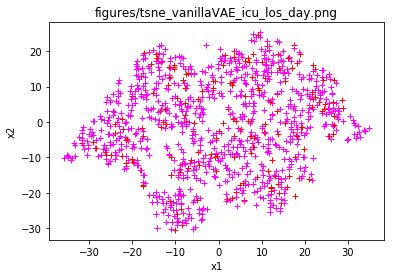

i is 999
scatter plot drawn


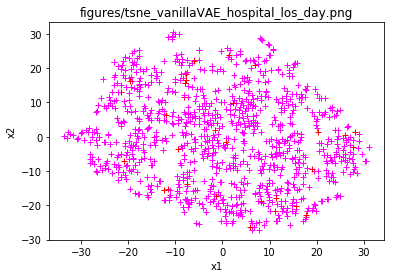

i is 999
scatter plot drawn


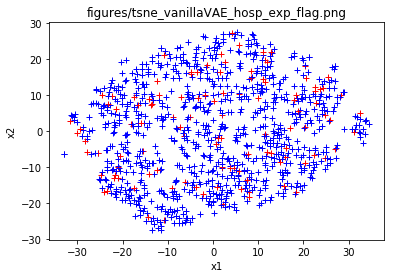

i is 999
scatter plot drawn


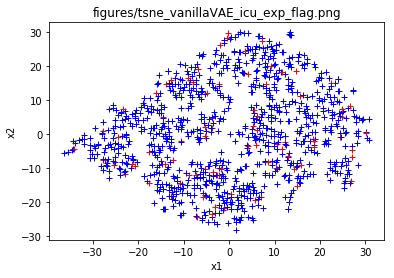

i is 999
scatter plot drawn


KeyboardInterrupt: 

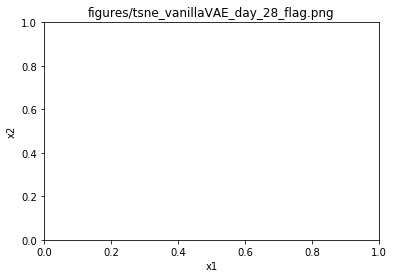

In [9]:
import sys
flag = 'hosp_exp_flag'
n_points = 1000
sys.path.append("/home/ubuntu/cs230_project/GMVAE_Experiments")
from utils import plot_labeled_data
import sklearn.manifold
latent_test = encoder.predict(X_train[:n_points])

for flag in Y_test.columns.values:
    plot_labeled_data(latent_test, np.array(Y_test[flag][:n_points]), 'figures/tsne_vanillaVAE_'+flag+'.png', True, perplexity=40)

### Plot Train Loss & Validation Loss vs. Number of Epochs to see our model's performance

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(history.history['squared_difference_loss'], label='Train Loss')
ax.plot(history.history['val_squared_difference_loss'], label='Validation Loss')

ax.legend()


ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

plt.title('VAE Loss vs. # of Epochs')
plt.show()

### Examining the relationship between the latent variables and the original variables

In [ ]:
input_vars = [c for c in X.columns if c not in outcome_vars]
n_examples = 20000
old_pats = X.iloc[:n_examples, :]
zvals = encoder.predict(np.array(old_pats.drop(outcome_vars, axis=1)))
# get some known patients.
min_z = -3
max_z = 3
skip = 1

latent_vars = {}
latent_input_var_spectra = {}
latent_outcome_var_spectra = {}
print("n_z = ",n_z)
for i in range(n_z):  # For each latent variable...
    latent_name = "z" + str(i)
    latent_vars[latent_name] = {}
    latent_input_var_spectra[latent_name] = np.zeros(len(input_vars))
    latent_outcome_var_spectra[latent_name] = np.zeros(len(outcome_vars))
    layer = latent_vars[latent_name]
    print("latent name",latent_name)
    for z in range(min_z, max_z, skip):  # ...fix the value of the latent variable (for a suite of values)
        zvals[:, i] = z
        new_pats = generator.predict(zvals)  # new_pats[0] is mu_x, new_pats[1] is sigma^2_x
        new_z = np.ones(n_examples) * z
        if "x" in layer:
            layer["x"] = np.concatenate((layer["x"], new_pats[0]))
        else:
            layer["x"] = new_pats[0]
        if "z" in layer:
            layer["z"] = np.concatenate((layer["z"], new_z), axis=0)
        else:
            layer["z"] = new_z
    # Take the correlation between the latent variable and all other original data variables,
    # we'll call this the latent variable's "fingerprint" or "spectrum" and we want to compare the different latent vars
    for j, real_varname in enumerate(input_vars):
        latent_input_var_spectra[latent_name][j] = np.corrcoef(latent_vars[latent_name]['z'], latent_vars[latent_name]['x'][:, j])[0, 1]
    for j, real_outcome_varname in enumerate(outcome_vars):
        correlations = np.corrcoef(latent_vars[latent_name]['z'], latent_vars[latent_name]['x'][:, j])[0, 1]
        latent_outcome_var_spectra[latent_name][j] = correlations
            
        

### Calculate the top n absolute value correlations for each latent variable

In [ ]:
n = 4
for i in range(n_z):
    latent_name = "z" + str(i)
    print('\nTop {} associated variables for Latent Variable {}:'.format(n, latent_name))
    top_n_associated_indxs = np.argsort(latent_input_var_spectra[latent_name])[::-1][:n]
    for association in zip(np.array(input_vars)[top_n_associated_indxs], 
                           latent_input_var_spectra[latent_name][top_n_associated_indxs]):
        print(association)
print('-----')   
for i in range(n_z):
    latent_name = "z" + str(i)
    print('\nTop {} associated variables for Latent Variable {}:'.format(n, latent_name))
    top_n_associated_indxs = np.argsort(latent_input_var_spectra[latent_name])[::-1][:n]
    for association in zip(np.array(outcome_vars)[top_n_associated_indxs], 
                           latent_input_var_spectra[latent_name][top_n_associated_indxs]):
        print(association)

## Show correlations for each variable

In [ ]:
for i in range(n_z):  # For each latent variable...
    plt.plot(latent_input_var_spectra["z" + str(i)], label="z" + str(i))
plt.xlabel('Original Variable Index')
plt.ylabel('Correlation with Latent Variable')
plt.title('Latent Variable Correlations for Vanilla VAE')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#pd.DataFrame(latent_input_var_spectra, index=X.columns).sort_values(by=['z0'])

In [ ]:
# plot each latent variable against each real value
x_z_data = []  # {x: xvals, z: zvals, varname}
fignum = 0
for z_i in range(n_z):
    latent_varname = "z" + str(z_i)
    print(latent_varname)
    for j, real_varname in enumerate(input_vars):
        fignum += 1
        title = latent_varname + "_vs_" + real_varname
        x_data = latent_vars[latent_varname]["x"][:,j]
        z_data = latent_vars[latent_varname]["z"]

        plt.scatter(z_data, x_data)  # we control the hidden var, z.
        plt.title(title)
        plt.xlabel(latent_varname)
        plt.ylabel(real_varname)
        plt.savefig("figures/title"+".png")

In [46]:
X[X.columns.values[:65]].head()

,age,weight_first,height_first,bmi,sofa_first,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,...,inr_min,inr_max,pt_min,pt_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max
0,-0.174367,-0.873550,0.083629,-0.986812,0.593058,1.114613,1.453867,0.973430,-0.168020,-1.294207,...,1.720931,0.600923,2.215430,0.980729,0.485343,-0.238332,2.951934,2.392836,-0.979649,-0.976192
1,-0.912443,-0.127044,0.159537,-0.237994,0.593058,0.057324,0.879022,0.885848,-0.928996,-0.343922,...,-0.100969,0.458634,-0.134198,0.639881,0.686075,0.844105,-0.252647,-0.324815,0.549150,2.729527
2,-0.578724,0.094646,-0.371818,-0.225810,-1.029837,-0.603482,-0.941321,-0.724069,-0.168020,-1.294207,...,-0.252794,-0.323959,-0.292156,-0.372008,-0.317582,-0.671307,-0.553076,-0.631647,-0.814029,0.090332
3,-1.198488,2.067231,0.652937,1.511980,-1.029837,0.585969,0.016754,0.546532,-0.222375,-0.219972,...,-0.404619,-0.323959,-0.331646,-0.340054,-0.317582,-0.021845,-0.803434,-0.675480,-0.329910,-0.226010
4,-0.955160,0.311811,-0.675449,0.740424,-0.380679,1.114613,0.112562,0.655540,-0.331086,-0.798406,...,-0.404619,-0.110524,-0.390880,-0.073767,-0.317582,0.627617,-0.452933,-0.543981,0.001330,0.054179


In [47]:
X[X.columns.values[:65]].head()

,age,weight_first,height_first,bmi,sofa_first,heartrate_min,heartrate_max,heartrate_mean,sysbp_min,sysbp_max,...,inr_min,inr_max,pt_min,pt_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max
0,-0.174367,-0.873550,0.083629,-0.986812,0.593058,1.114613,1.453867,0.973430,-0.168020,-1.294207,...,1.720931,0.600923,2.215430,0.980729,0.485343,-0.238332,2.951934,2.392836,-0.979649,-0.976192
1,-0.912443,-0.127044,0.159537,-0.237994,0.593058,0.057324,0.879022,0.885848,-0.928996,-0.343922,...,-0.100969,0.458634,-0.134198,0.639881,0.686075,0.844105,-0.252647,-0.324815,0.549150,2.729527
2,-0.578724,0.094646,-0.371818,-0.225810,-1.029837,-0.603482,-0.941321,-0.724069,-0.168020,-1.294207,...,-0.252794,-0.323959,-0.292156,-0.372008,-0.317582,-0.671307,-0.553076,-0.631647,-0.814029,0.090332
3,-1.198488,2.067231,0.652937,1.511980,-1.029837,0.585969,0.016754,0.546532,-0.222375,-0.219972,...,-0.404619,-0.323959,-0.331646,-0.340054,-0.317582,-0.021845,-0.803434,-0.675480,-0.329910,-0.226010
4,-0.955160,0.311811,-0.675449,0.740424,-0.380679,1.114613,0.112562,0.655540,-0.331086,-0.798406,...,-0.404619,-0.110524,-0.390880,-0.073767,-0.317582,0.627617,-0.452933,-0.543981,0.001330,0.054179


In [ ]:
from sklearn.model_selection import KFold
X_mat = np.array(X[X.columns.values[:65]])

n_folds = 5

num_latent_vars = [3, 4, 5, 6, 7]
num_hidden_vars = [10, 20, 30, 40, 50, 60]
# num_latent_vars = [5, 10, 15, 20, 25, 30, 50, 75, 100, 150, 250, 500, 1000]
# num_hidden_vars = [10, 25, 50, 100, 250, 500, 750, 1000, 1500, 2500, 5000]
cv_results = pd.DataFrame(0,
                           index=num_latent_vars,
                           columns=num_hidden_vars)

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
kf.get_n_splits(X_mat)

i = 1
for lat_var_num in num_latent_vars:
    for hid_var_num in num_hidden_vars:
        print("Latent Var Num = {}".format(lat_var_num))
        print("Hidden Var Num = {}".format(hid_var_num))
        fold_num = 1
        total_nll = 0.
        
        print('Simulation #{}: VAE with {} Latent Variable(s) and {} Hidden Variable(s)...'.format(i, lat_var_num, hid_var_num))
        
        for train_index, test_index in kf.split(X_mat):
            X_train, X_test = X_mat[train_index], X_mat[test_index]
            print("\tEvaluating model on Fold {}".format(fold_num))
            total_nll += evaluate_vae_model(X_train, 
                                            X_test, 
                                            latent_dimensions=lat_var_num, 
                                            intermediate_dimensions=hid_var_num, n_epochs=50)[0]
            if total_nll == float('NaN'):
                break
            fold_num += 1
            if fold_num > 1:
                break

        cv_results.loc[lat_var_num, hid_var_num] = total_nll #/ n_folds
        print('\tAverage Validation Squared Error = {}'.format(total_nll))# / n_folds))
        i += 1

Latent Var Num = 3
Hidden Var Num = 10
Simulation #1: VAE with 3 Latent Variable(s) and 10 Hidden Variable(s)...
	Evaluating model on Fold 1
Train on 29329 samples, validate on 12570 samples
Epoch 1/50
 - 12s - loss: 104.7182 - squared_difference_loss: 84.8179 - KL_divergence_loss: 2.5782 - neg_log_likelihood: 102.1399 - val_loss: 91.5247 - val_squared_difference_loss: 58.8726 - val_KL_divergence_loss: 2.3574 - val_neg_log_likelihood: 89.1673
Epoch 2/50
 - 1s - loss: 89.1371 - squared_difference_loss: 56.2116 - KL_divergence_loss: 1.3003 - neg_log_likelihood: 87.8368 - val_loss: 87.9612 - val_squared_difference_loss: 52.9963 - val_KL_divergence_loss: 1.7321 - val_neg_log_likelihood: 86.2292
Epoch 3/50
 - 1s - loss: 87.3067 - squared_difference_loss: 52.3294 - KL_divergence_loss: 1.4111 - neg_log_likelihood: 85.8957 - val_loss: 86.8326 - val_squared_difference_loss: 49.4326 - val_KL_divergence_loss: 2.3853 - val_neg_log_likelihood: 84.4473
Epoch 4/50
 - 1s - loss: 86.3690 - squared_diff

Epoch 33/50
 - 1s - loss: 84.3043 - squared_difference_loss: 43.8837 - KL_divergence_loss: 2.6314 - neg_log_likelihood: 81.6729 - val_loss: 84.7724 - val_squared_difference_loss: 44.5041 - val_KL_divergence_loss: 2.7894 - val_neg_log_likelihood: 81.9831
Epoch 34/50
 - 1s - loss: 84.2601 - squared_difference_loss: 43.6978 - KL_divergence_loss: 2.6802 - neg_log_likelihood: 81.5799 - val_loss: 84.8037 - val_squared_difference_loss: 44.8554 - val_KL_divergence_loss: 2.6450 - val_neg_log_likelihood: 82.1587
	Average Validation Squared Error = 82.13622222597867
Latent Var Num = 3
Hidden Var Num = 20
Simulation #2: VAE with 3 Latent Variable(s) and 20 Hidden Variable(s)...
	Evaluating model on Fold 1
Train on 29329 samples, validate on 12570 samples
Epoch 1/50
 - 12s - loss: 100.0771 - squared_difference_loss: 76.2332 - KL_divergence_loss: 2.2295 - neg_log_likelihood: 97.8476 - val_loss: 88.6045 - val_squared_difference_loss: 53.3908 - val_KL_divergence_loss: 2.1781 - val_neg_log_likelihood: 

Epoch 31/50
 - 1s - loss: 83.5029 - squared_difference_loss: 41.5290 - KL_divergence_loss: 3.0074 - neg_log_likelihood: 80.4955 - val_loss: 83.2954 - val_squared_difference_loss: 41.0098 - val_KL_divergence_loss: 3.0595 - val_neg_log_likelihood: 80.2359
Epoch 32/50
 - 1s - loss: 83.5138 - squared_difference_loss: 41.5984 - KL_divergence_loss: 2.9836 - neg_log_likelihood: 80.5302 - val_loss: 83.1316 - val_squared_difference_loss: 40.5967 - val_KL_divergence_loss: 3.1022 - val_neg_log_likelihood: 80.0294
Epoch 33/50
 - 1s - loss: 83.4891 - squared_difference_loss: 41.4918 - KL_divergence_loss: 3.0122 - neg_log_likelihood: 80.4769 - val_loss: 83.1332 - val_squared_difference_loss: 40.6652 - val_KL_divergence_loss: 3.0695 - val_neg_log_likelihood: 80.0636
Epoch 34/50
 - 1s - loss: 83.4540 - squared_difference_loss: 41.4873 - KL_divergence_loss: 2.9794 - neg_log_likelihood: 80.4747 - val_loss: 83.1325 - val_squared_difference_loss: 40.5564 - val_KL_divergence_loss: 3.1233 - val_neg_log_like

Epoch 13/50
 - 1s - loss: 83.8675 - squared_difference_loss: 42.5261 - KL_divergence_loss: 2.8735 - neg_log_likelihood: 80.9940 - val_loss: 83.5454 - val_squared_difference_loss: 41.3930 - val_KL_divergence_loss: 3.1179 - val_neg_log_likelihood: 80.4275
Epoch 14/50
 - 1s - loss: 83.8107 - squared_difference_loss: 42.4240 - KL_divergence_loss: 2.8677 - neg_log_likelihood: 80.9430 - val_loss: 83.5180 - val_squared_difference_loss: 41.3877 - val_KL_divergence_loss: 3.0931 - val_neg_log_likelihood: 80.4249
Epoch 15/50
 - 1s - loss: 83.7686 - squared_difference_loss: 42.3502 - KL_divergence_loss: 2.8624 - neg_log_likelihood: 80.9061 - val_loss: 83.5006 - val_squared_difference_loss: 41.6086 - val_KL_divergence_loss: 2.9653 - val_neg_log_likelihood: 80.5353
Epoch 16/50
 - 1s - loss: 83.7262 - squared_difference_loss: 42.2706 - KL_divergence_loss: 2.8599 - neg_log_likelihood: 80.8663 - val_loss: 83.4755 - val_squared_difference_loss: 41.3607 - val_KL_divergence_loss: 3.0642 - val_neg_log_like

Epoch 46/50
 - 1s - loss: 83.0176 - squared_difference_loss: 40.4763 - KL_divergence_loss: 3.0485 - neg_log_likelihood: 79.9691 - val_loss: 82.8475 - val_squared_difference_loss: 39.8062 - val_KL_divergence_loss: 3.2135 - val_neg_log_likelihood: 79.6341
Epoch 47/50
 - 1s - loss: 82.9762 - squared_difference_loss: 40.3781 - KL_divergence_loss: 3.0562 - neg_log_likelihood: 79.9200 - val_loss: 82.8298 - val_squared_difference_loss: 40.0713 - val_KL_divergence_loss: 3.0631 - val_neg_log_likelihood: 79.7667
Epoch 48/50
 - 1s - loss: 82.9715 - squared_difference_loss: 40.4042 - KL_divergence_loss: 3.0384 - neg_log_likelihood: 79.9331 - val_loss: 82.8466 - val_squared_difference_loss: 39.9647 - val_KL_divergence_loss: 3.1332 - val_neg_log_likelihood: 79.7134
Epoch 49/50
 - 1s - loss: 82.9820 - squared_difference_loss: 40.3660 - KL_divergence_loss: 3.0679 - neg_log_likelihood: 79.9140 - val_loss: 82.8915 - val_squared_difference_loss: 40.2285 - val_KL_divergence_loss: 3.0463 - val_neg_log_like

Epoch 28/50
 - 1s - loss: 83.1673 - squared_difference_loss: 40.7627 - KL_divergence_loss: 3.0549 - neg_log_likelihood: 80.1124 - val_loss: 83.0585 - val_squared_difference_loss: 40.0601 - val_KL_divergence_loss: 3.2975 - val_neg_log_likelihood: 79.7610
Epoch 29/50
 - 1s - loss: 83.0900 - squared_difference_loss: 40.5127 - KL_divergence_loss: 3.1026 - neg_log_likelihood: 79.9874 - val_loss: 82.8778 - val_squared_difference_loss: 40.0291 - val_KL_divergence_loss: 3.1323 - val_neg_log_likelihood: 79.7456
Epoch 30/50
 - 1s - loss: 83.0394 - squared_difference_loss: 40.4460 - KL_divergence_loss: 3.0854 - neg_log_likelihood: 79.9540 - val_loss: 82.9562 - val_squared_difference_loss: 40.0886 - val_KL_divergence_loss: 3.1809 - val_neg_log_likelihood: 79.7753
Epoch 31/50
 - 1s - loss: 83.0986 - squared_difference_loss: 40.4926 - KL_divergence_loss: 3.1213 - neg_log_likelihood: 79.9773 - val_loss: 82.9018 - val_squared_difference_loss: 40.0812 - val_KL_divergence_loss: 3.1303 - val_neg_log_like

Epoch 10/50
 - 1s - loss: 83.8064 - squared_difference_loss: 42.3031 - KL_divergence_loss: 2.9239 - neg_log_likelihood: 80.8825 - val_loss: 83.6721 - val_squared_difference_loss: 41.5173 - val_KL_divergence_loss: 3.1825 - val_neg_log_likelihood: 80.4896
Epoch 11/50
 - 1s - loss: 83.7249 - squared_difference_loss: 42.0835 - KL_divergence_loss: 2.9522 - neg_log_likelihood: 80.7727 - val_loss: 83.9023 - val_squared_difference_loss: 42.2142 - val_KL_divergence_loss: 3.0642 - val_neg_log_likelihood: 80.8381
Epoch 12/50
 - 1s - loss: 83.6681 - squared_difference_loss: 41.9485 - KL_divergence_loss: 2.9629 - neg_log_likelihood: 80.7053 - val_loss: 83.6217 - val_squared_difference_loss: 41.5299 - val_KL_divergence_loss: 3.1257 - val_neg_log_likelihood: 80.4960
Epoch 13/50
 - 1s - loss: 83.6208 - squared_difference_loss: 41.8567 - KL_divergence_loss: 2.9615 - neg_log_likelihood: 80.6593 - val_loss: 83.5010 - val_squared_difference_loss: 41.3654 - val_KL_divergence_loss: 3.0873 - val_neg_log_like

Epoch 43/50
 - 1s - loss: 82.6774 - squared_difference_loss: 39.5816 - KL_divergence_loss: 3.1555 - neg_log_likelihood: 79.5218 - val_loss: 82.7084 - val_squared_difference_loss: 39.6787 - val_KL_divergence_loss: 3.1381 - val_neg_log_likelihood: 79.5703
Epoch 44/50
 - 1s - loss: 82.6652 - squared_difference_loss: 39.5255 - KL_divergence_loss: 3.1714 - neg_log_likelihood: 79.4938 - val_loss: 82.6305 - val_squared_difference_loss: 39.5680 - val_KL_divergence_loss: 3.1155 - val_neg_log_likelihood: 79.5150
Epoch 45/50
 - 1s - loss: 82.6741 - squared_difference_loss: 39.5554 - KL_divergence_loss: 3.1654 - neg_log_likelihood: 79.5087 - val_loss: 82.6253 - val_squared_difference_loss: 39.3932 - val_KL_divergence_loss: 3.1978 - val_neg_log_likelihood: 79.4276
Epoch 46/50
 - 1s - loss: 82.6793 - squared_difference_loss: 39.5142 - KL_divergence_loss: 3.1912 - neg_log_likelihood: 79.4881 - val_loss: 82.7085 - val_squared_difference_loss: 39.4785 - val_KL_divergence_loss: 3.2382 - val_neg_log_like

Epoch 25/50
 - 1s - loss: 82.9209 - squared_difference_loss: 40.1612 - KL_divergence_loss: 3.1093 - neg_log_likelihood: 79.8116 - val_loss: 82.8682 - val_squared_difference_loss: 40.1311 - val_KL_divergence_loss: 3.0716 - val_neg_log_likelihood: 79.7965
Epoch 26/50
 - 1s - loss: 82.8666 - squared_difference_loss: 40.0459 - KL_divergence_loss: 3.1126 - neg_log_likelihood: 79.7539 - val_loss: 82.8696 - val_squared_difference_loss: 39.9458 - val_KL_divergence_loss: 3.1658 - val_neg_log_likelihood: 79.7039
Epoch 27/50
 - 1s - loss: 82.8131 - squared_difference_loss: 39.9148 - KL_divergence_loss: 3.1247 - neg_log_likelihood: 79.6884 - val_loss: 82.7667 - val_squared_difference_loss: 39.5596 - val_KL_divergence_loss: 3.2559 - val_neg_log_likelihood: 79.5108
Epoch 28/50
 - 1s - loss: 82.8174 - squared_difference_loss: 39.9165 - KL_divergence_loss: 3.1282 - neg_log_likelihood: 79.6892 - val_loss: 82.7855 - val_squared_difference_loss: 39.8968 - val_KL_divergence_loss: 3.1061 - val_neg_log_like

Epoch 7/50
 - 1s - loss: 85.2121 - squared_difference_loss: 46.3022 - KL_divergence_loss: 2.3300 - neg_log_likelihood: 82.8821 - val_loss: 84.8966 - val_squared_difference_loss: 45.2132 - val_KL_divergence_loss: 2.5591 - val_neg_log_likelihood: 82.3376
Epoch 8/50
 - 1s - loss: 85.0979 - squared_difference_loss: 46.0010 - KL_divergence_loss: 2.3664 - neg_log_likelihood: 82.7315 - val_loss: 84.8162 - val_squared_difference_loss: 45.0376 - val_KL_divergence_loss: 2.5664 - val_neg_log_likelihood: 82.2498
Epoch 9/50
 - 1s - loss: 85.0173 - squared_difference_loss: 45.7797 - KL_divergence_loss: 2.3964 - neg_log_likelihood: 82.6209 - val_loss: 84.6894 - val_squared_difference_loss: 44.6748 - val_KL_divergence_loss: 2.6210 - val_neg_log_likelihood: 82.0684
Epoch 10/50
 - 1s - loss: 84.9655 - squared_difference_loss: 45.5608 - KL_divergence_loss: 2.4541 - neg_log_likelihood: 82.5114 - val_loss: 84.6370 - val_squared_difference_loss: 44.6277 - val_KL_divergence_loss: 2.5922 - val_neg_log_likelih

Epoch 40/50
 - 1s - loss: 83.7655 - squared_difference_loss: 42.4080 - KL_divergence_loss: 2.8304 - neg_log_likelihood: 80.9350 - val_loss: 84.1031 - val_squared_difference_loss: 43.0587 - val_KL_divergence_loss: 2.8427 - val_neg_log_likelihood: 81.2604
Epoch 41/50
 - 1s - loss: 83.7449 - squared_difference_loss: 42.3419 - KL_divergence_loss: 2.8429 - neg_log_likelihood: 80.9020 - val_loss: 84.3119 - val_squared_difference_loss: 43.4846 - val_KL_divergence_loss: 2.8386 - val_neg_log_likelihood: 81.4733
Epoch 42/50
 - 1s - loss: 83.7563 - squared_difference_loss: 42.3470 - KL_divergence_loss: 2.8518 - neg_log_likelihood: 80.9045 - val_loss: 84.1907 - val_squared_difference_loss: 43.2057 - val_KL_divergence_loss: 2.8568 - val_neg_log_likelihood: 81.3339
	Average Validation Squared Error = 81.1393634832046
Latent Var Num = 4
Hidden Var Num = 20
Simulation #8: VAE with 4 Latent Variable(s) and 20 Hidden Variable(s)...
	Evaluating model on Fold 1
Train on 29329 samples, validate on 12570 sa

Epoch 30/50
 - 1s - loss: 82.8876 - squared_difference_loss: 39.3055 - KL_divergence_loss: 3.5038 - neg_log_likelihood: 79.3838 - val_loss: 82.7590 - val_squared_difference_loss: 39.0312 - val_KL_divergence_loss: 3.5124 - val_neg_log_likelihood: 79.2466
Epoch 31/50
 - 1s - loss: 82.8303 - squared_difference_loss: 39.1780 - KL_divergence_loss: 3.5103 - neg_log_likelihood: 79.3200 - val_loss: 82.7387 - val_squared_difference_loss: 38.7588 - val_KL_divergence_loss: 3.6283 - val_neg_log_likelihood: 79.1104
Epoch 32/50
 - 1s - loss: 82.7981 - squared_difference_loss: 39.0787 - KL_divergence_loss: 3.5278 - neg_log_likelihood: 79.2703 - val_loss: 82.9562 - val_squared_difference_loss: 39.6233 - val_KL_divergence_loss: 3.4136 - val_neg_log_likelihood: 79.5427
Epoch 33/50
 - 1s - loss: 82.7490 - squared_difference_loss: 39.0450 - KL_divergence_loss: 3.4955 - neg_log_likelihood: 79.2535 - val_loss: 82.8097 - val_squared_difference_loss: 38.8694 - val_KL_divergence_loss: 3.6440 - val_neg_log_like

Epoch 25/50
 - 1s - loss: 82.7449 - squared_difference_loss: 38.8913 - KL_divergence_loss: 3.5682 - neg_log_likelihood: 79.1767 - val_loss: 82.7719 - val_squared_difference_loss: 39.1273 - val_KL_divergence_loss: 3.4773 - val_neg_log_likelihood: 79.2946
Epoch 26/50
 - 1s - loss: 82.7700 - squared_difference_loss: 38.9301 - KL_divergence_loss: 3.5739 - neg_log_likelihood: 79.1960 - val_loss: 82.6889 - val_squared_difference_loss: 38.7882 - val_KL_divergence_loss: 3.5637 - val_neg_log_likelihood: 79.1251
Epoch 27/50
 - 1s - loss: 82.6962 - squared_difference_loss: 38.7639 - KL_divergence_loss: 3.5832 - neg_log_likelihood: 79.1130 - val_loss: 82.5831 - val_squared_difference_loss: 38.4407 - val_KL_divergence_loss: 3.6318 - val_neg_log_likelihood: 78.9513
Epoch 28/50
 - 1s - loss: 82.7043 - squared_difference_loss: 38.7301 - KL_divergence_loss: 3.6083 - neg_log_likelihood: 79.0960 - val_loss: 82.5466 - val_squared_difference_loss: 38.2877 - val_KL_divergence_loss: 3.6718 - val_neg_log_like

Epoch 7/50
 - 1s - loss: 83.5464 - squared_difference_loss: 40.6300 - KL_divergence_loss: 3.5004 - neg_log_likelihood: 80.0460 - val_loss: 83.4482 - val_squared_difference_loss: 40.0077 - val_KL_divergence_loss: 3.7134 - val_neg_log_likelihood: 79.7348
Epoch 8/50
 - 1s - loss: 83.4114 - squared_difference_loss: 40.3485 - KL_divergence_loss: 3.5062 - neg_log_likelihood: 79.9053 - val_loss: 83.5113 - val_squared_difference_loss: 39.9878 - val_KL_divergence_loss: 3.7864 - val_neg_log_likelihood: 79.7249
Epoch 9/50
 - 1s - loss: 83.3014 - squared_difference_loss: 40.0508 - KL_divergence_loss: 3.5450 - neg_log_likelihood: 79.7564 - val_loss: 83.3537 - val_squared_difference_loss: 39.7301 - val_KL_divergence_loss: 3.7576 - val_neg_log_likelihood: 79.5961
Epoch 10/50
 - 1s - loss: 83.1895 - squared_difference_loss: 39.8201 - KL_divergence_loss: 3.5485 - neg_log_likelihood: 79.6411 - val_loss: 83.3554 - val_squared_difference_loss: 39.7506 - val_KL_divergence_loss: 3.7491 - val_neg_log_likelih

Epoch 40/50
 - 1s - loss: 82.2464 - squared_difference_loss: 37.6336 - KL_divergence_loss: 3.6986 - neg_log_likelihood: 78.5478 - val_loss: 82.1509 - val_squared_difference_loss: 37.1351 - val_KL_divergence_loss: 3.8523 - val_neg_log_likelihood: 78.2986
Epoch 41/50
 - 1s - loss: 82.2246 - squared_difference_loss: 37.5420 - KL_divergence_loss: 3.7226 - neg_log_likelihood: 78.5020 - val_loss: 82.1994 - val_squared_difference_loss: 37.6717 - val_KL_divergence_loss: 3.6326 - val_neg_log_likelihood: 78.5669
Epoch 42/50
 - 1s - loss: 82.2242 - squared_difference_loss: 37.5615 - KL_divergence_loss: 3.7125 - neg_log_likelihood: 78.5117 - val_loss: 82.2988 - val_squared_difference_loss: 37.5038 - val_KL_divergence_loss: 3.8159 - val_neg_log_likelihood: 78.4829
Epoch 43/50
 - 1s - loss: 82.2360 - squared_difference_loss: 37.5081 - KL_divergence_loss: 3.7509 - neg_log_likelihood: 78.4850 - val_loss: 82.2937 - val_squared_difference_loss: 37.9190 - val_KL_divergence_loss: 3.6032 - val_neg_log_like

Epoch 22/50
 - 1s - loss: 82.4529 - squared_difference_loss: 37.9991 - KL_divergence_loss: 3.7224 - neg_log_likelihood: 78.7305 - val_loss: 82.4439 - val_squared_difference_loss: 38.0819 - val_KL_divergence_loss: 3.6719 - val_neg_log_likelihood: 78.7720
Epoch 23/50
 - 1s - loss: 82.4432 - squared_difference_loss: 38.0036 - KL_divergence_loss: 3.7104 - neg_log_likelihood: 78.7328 - val_loss: 82.4371 - val_squared_difference_loss: 37.5043 - val_KL_divergence_loss: 3.9539 - val_neg_log_likelihood: 78.4832
Epoch 24/50
 - 1s - loss: 82.3816 - squared_difference_loss: 37.7948 - KL_divergence_loss: 3.7532 - neg_log_likelihood: 78.6284 - val_loss: 82.3626 - val_squared_difference_loss: 37.7826 - val_KL_divergence_loss: 3.7403 - val_neg_log_likelihood: 78.6223
Epoch 25/50
 - 1s - loss: 82.3822 - squared_difference_loss: 37.8635 - KL_divergence_loss: 3.7194 - neg_log_likelihood: 78.6628 - val_loss: 82.2907 - val_squared_difference_loss: 37.5180 - val_KL_divergence_loss: 3.8007 - val_neg_log_like

Epoch 4/50
 - 1s - loss: 83.9656 - squared_difference_loss: 41.6592 - KL_divergence_loss: 3.4050 - neg_log_likelihood: 80.5606 - val_loss: 83.6893 - val_squared_difference_loss: 40.2308 - val_KL_divergence_loss: 3.8429 - val_neg_log_likelihood: 79.8464
Epoch 5/50
 - 2s - loss: 83.7857 - squared_difference_loss: 41.1570 - KL_divergence_loss: 3.4762 - neg_log_likelihood: 80.3095 - val_loss: 83.5893 - val_squared_difference_loss: 40.0666 - val_KL_divergence_loss: 3.8250 - val_neg_log_likelihood: 79.7643
Epoch 6/50
 - 1s - loss: 83.6530 - squared_difference_loss: 40.8865 - KL_divergence_loss: 3.4787 - neg_log_likelihood: 80.1742 - val_loss: 83.4784 - val_squared_difference_loss: 39.9118 - val_KL_divergence_loss: 3.7915 - val_neg_log_likelihood: 79.6869
Epoch 7/50
 - 1s - loss: 83.5337 - squared_difference_loss: 40.6242 - KL_divergence_loss: 3.4906 - neg_log_likelihood: 80.0431 - val_loss: 83.3687 - val_squared_difference_loss: 40.0099 - val_KL_divergence_loss: 3.6328 - val_neg_log_likeliho

Epoch 37/50
 - 1s - loss: 82.2518 - squared_difference_loss: 37.6302 - KL_divergence_loss: 3.7057 - neg_log_likelihood: 78.5461 - val_loss: 82.2841 - val_squared_difference_loss: 37.3199 - val_KL_divergence_loss: 3.8932 - val_neg_log_likelihood: 78.3909
Epoch 38/50
 - 1s - loss: 82.2706 - squared_difference_loss: 37.6200 - KL_divergence_loss: 3.7296 - neg_log_likelihood: 78.5410 - val_loss: 82.2837 - val_squared_difference_loss: 37.7225 - val_KL_divergence_loss: 3.6914 - val_neg_log_likelihood: 78.5922
Epoch 39/50
 - 1s - loss: 82.2146 - squared_difference_loss: 37.5744 - KL_divergence_loss: 3.6964 - neg_log_likelihood: 78.5182 - val_loss: 82.4693 - val_squared_difference_loss: 37.4964 - val_KL_divergence_loss: 3.9902 - val_neg_log_likelihood: 78.4792
Epoch 40/50
 - 1s - loss: 82.2612 - squared_difference_loss: 37.5779 - KL_divergence_loss: 3.7413 - neg_log_likelihood: 78.5199 - val_loss: 82.2193 - val_squared_difference_loss: 37.3202 - val_KL_divergence_loss: 3.8282 - val_neg_log_like

Epoch 19/50
 - 1s - loss: 83.9700 - squared_difference_loss: 41.8156 - KL_divergence_loss: 3.3312 - neg_log_likelihood: 80.6388 - val_loss: 83.8025 - val_squared_difference_loss: 41.3596 - val_KL_divergence_loss: 3.3917 - val_neg_log_likelihood: 80.4108
Epoch 20/50
 - 1s - loss: 83.9383 - squared_difference_loss: 41.6889 - KL_divergence_loss: 3.3628 - neg_log_likelihood: 80.5755 - val_loss: 83.7506 - val_squared_difference_loss: 41.1530 - val_KL_divergence_loss: 3.4431 - val_neg_log_likelihood: 80.3075
Epoch 21/50
 - 1s - loss: 83.8904 - squared_difference_loss: 41.5256 - KL_divergence_loss: 3.3966 - neg_log_likelihood: 80.4938 - val_loss: 83.7438 - val_squared_difference_loss: 41.1848 - val_KL_divergence_loss: 3.4204 - val_neg_log_likelihood: 80.3234
Epoch 22/50
 - 1s - loss: 83.8407 - squared_difference_loss: 41.4456 - KL_divergence_loss: 3.3869 - neg_log_likelihood: 80.4538 - val_loss: 83.5777 - val_squared_difference_loss: 40.7190 - val_KL_divergence_loss: 3.4872 - val_neg_log_like

Train on 29329 samples, validate on 12570 samples
Epoch 1/50
 - 14s - loss: 101.5148 - squared_difference_loss: 77.8872 - KL_divergence_loss: 2.8402 - neg_log_likelihood: 98.6746 - val_loss: 89.0522 - val_squared_difference_loss: 52.0815 - val_KL_divergence_loss: 3.2804 - val_neg_log_likelihood: 85.7718
Epoch 2/50
 - 1s - loss: 86.9669 - squared_difference_loss: 50.1726 - KL_divergence_loss: 2.1496 - neg_log_likelihood: 84.8173 - val_loss: 85.8092 - val_squared_difference_loss: 46.1574 - val_KL_divergence_loss: 2.9995 - val_neg_log_likelihood: 82.8097
Epoch 3/50
 - 1s - loss: 85.6602 - squared_difference_loss: 46.6728 - KL_divergence_loss: 2.5928 - neg_log_likelihood: 83.0674 - val_loss: 84.9789 - val_squared_difference_loss: 43.9801 - val_KL_divergence_loss: 3.2579 - val_neg_log_likelihood: 81.7210
Epoch 4/50
 - 1s - loss: 85.0490 - squared_difference_loss: 44.8139 - KL_divergence_loss: 2.9111 - neg_log_likelihood: 82.1379 - val_loss: 84.5226 - val_squared_difference_loss: 42.3117 - v

Epoch 34/50
 - 1s - loss: 82.1940 - squared_difference_loss: 36.7571 - KL_divergence_loss: 4.0845 - neg_log_likelihood: 78.1095 - val_loss: 82.0863 - val_squared_difference_loss: 36.5025 - val_KL_divergence_loss: 4.1040 - val_neg_log_likelihood: 77.9823
Epoch 35/50
 - 1s - loss: 82.1810 - squared_difference_loss: 36.6989 - KL_divergence_loss: 4.1006 - neg_log_likelihood: 78.0804 - val_loss: 82.0989 - val_squared_difference_loss: 36.2549 - val_KL_divergence_loss: 4.2404 - val_neg_log_likelihood: 77.8585
Epoch 36/50
 - 1s - loss: 82.1216 - squared_difference_loss: 36.5909 - KL_divergence_loss: 4.0952 - neg_log_likelihood: 78.0264 - val_loss: 82.0700 - val_squared_difference_loss: 36.5674 - val_KL_divergence_loss: 4.0553 - val_neg_log_likelihood: 78.0147
Epoch 37/50
 - 1s - loss: 82.1639 - squared_difference_loss: 36.7399 - KL_divergence_loss: 4.0629 - neg_log_likelihood: 78.1010 - val_loss: 82.0750 - val_squared_difference_loss: 36.3606 - val_KL_divergence_loss: 4.1637 - val_neg_log_like

Epoch 16/50
 - 1s - loss: 82.6152 - squared_difference_loss: 37.5727 - KL_divergence_loss: 4.0979 - neg_log_likelihood: 78.5173 - val_loss: 82.8420 - val_squared_difference_loss: 38.1470 - val_KL_divergence_loss: 4.0375 - val_neg_log_likelihood: 78.8045
Epoch 17/50
 - 1s - loss: 82.5664 - squared_difference_loss: 37.5194 - KL_divergence_loss: 4.0757 - neg_log_likelihood: 78.4907 - val_loss: 82.6367 - val_squared_difference_loss: 37.6803 - val_KL_divergence_loss: 4.0655 - val_neg_log_likelihood: 78.5712
Epoch 18/50
 - 1s - loss: 82.4843 - squared_difference_loss: 37.3732 - KL_divergence_loss: 4.0667 - neg_log_likelihood: 78.4176 - val_loss: 82.6923 - val_squared_difference_loss: 37.3441 - val_KL_divergence_loss: 4.2893 - val_neg_log_likelihood: 78.4030
Epoch 19/50
 - 1s - loss: 82.4432 - squared_difference_loss: 37.1807 - KL_divergence_loss: 4.1218 - neg_log_likelihood: 78.3213 - val_loss: 82.7082 - val_squared_difference_loss: 37.5757 - val_KL_divergence_loss: 4.1893 - val_neg_log_like

Epoch 49/50
 - 1s - loss: 81.8120 - squared_difference_loss: 35.6765 - KL_divergence_loss: 4.2428 - neg_log_likelihood: 77.5693 - val_loss: 81.9999 - val_squared_difference_loss: 36.1091 - val_KL_divergence_loss: 4.2144 - val_neg_log_likelihood: 77.7855
Epoch 50/50
 - 1s - loss: 81.7781 - squared_difference_loss: 35.7212 - KL_divergence_loss: 4.1865 - neg_log_likelihood: 77.5916 - val_loss: 81.9328 - val_squared_difference_loss: 35.9014 - val_KL_divergence_loss: 4.2510 - val_neg_log_likelihood: 77.6817
	Average Validation Squared Error = 75.84467640141108
Latent Var Num = 5
Hidden Var Num = 40
Simulation #16: VAE with 5 Latent Variable(s) and 40 Hidden Variable(s)...
	Evaluating model on Fold 1
Train on 29329 samples, validate on 12570 samples
Epoch 1/50
 - 15s - loss: 96.6751 - squared_difference_loss: 67.3696 - KL_divergence_loss: 3.2593 - neg_log_likelihood: 93.4158 - val_loss: 87.1839 - val_squared_difference_loss: 46.8194 - val_KL_divergence_loss: 4.0432 - val_neg_log_likelihood: 

Epoch 31/50
 - 1s - loss: 81.8337 - squared_difference_loss: 35.8583 - KL_divergence_loss: 4.1735 - neg_log_likelihood: 77.6602 - val_loss: 81.8110 - val_squared_difference_loss: 35.3972 - val_KL_divergence_loss: 4.3813 - val_neg_log_likelihood: 77.4296
Epoch 32/50
 - 1s - loss: 81.8248 - squared_difference_loss: 35.7502 - KL_divergence_loss: 4.2187 - neg_log_likelihood: 77.6061 - val_loss: 81.7163 - val_squared_difference_loss: 35.5350 - val_KL_divergence_loss: 4.2177 - val_neg_log_likelihood: 77.4985
Epoch 33/50
 - 1s - loss: 81.8435 - squared_difference_loss: 35.8401 - KL_divergence_loss: 4.1924 - neg_log_likelihood: 77.6510 - val_loss: 81.6996 - val_squared_difference_loss: 35.5988 - val_KL_divergence_loss: 4.1691 - val_neg_log_likelihood: 77.5304
Epoch 34/50
 - 1s - loss: 81.8175 - squared_difference_loss: 35.7983 - KL_divergence_loss: 4.1874 - neg_log_likelihood: 77.6302 - val_loss: 81.7291 - val_squared_difference_loss: 35.4391 - val_KL_divergence_loss: 4.2786 - val_neg_log_like

Epoch 13/50
 - 1s - loss: 82.4026 - squared_difference_loss: 37.1481 - KL_divergence_loss: 4.0975 - neg_log_likelihood: 78.3051 - val_loss: 82.4794 - val_squared_difference_loss: 36.8003 - val_KL_divergence_loss: 4.3483 - val_neg_log_likelihood: 78.1312
Epoch 14/50
 - 1s - loss: 82.3179 - squared_difference_loss: 36.8277 - KL_divergence_loss: 4.1730 - neg_log_likelihood: 78.1449 - val_loss: 82.4487 - val_squared_difference_loss: 36.6276 - val_KL_divergence_loss: 4.4039 - val_neg_log_likelihood: 78.0448
Epoch 15/50
 - 1s - loss: 82.2406 - squared_difference_loss: 36.6318 - KL_divergence_loss: 4.1937 - neg_log_likelihood: 78.0469 - val_loss: 82.4397 - val_squared_difference_loss: 37.0116 - val_KL_divergence_loss: 4.2029 - val_neg_log_likelihood: 78.2368
Epoch 16/50
 - 1s - loss: 82.2049 - squared_difference_loss: 36.6241 - KL_divergence_loss: 4.1618 - neg_log_likelihood: 78.0430 - val_loss: 82.4243 - val_squared_difference_loss: 36.7667 - val_KL_divergence_loss: 4.3099 - val_neg_log_like

Epoch 46/50
 - 1s - loss: 81.5842 - squared_difference_loss: 35.1537 - KL_divergence_loss: 4.2764 - neg_log_likelihood: 77.3079 - val_loss: 81.5370 - val_squared_difference_loss: 35.1214 - val_KL_divergence_loss: 4.2452 - val_neg_log_likelihood: 77.2917
Epoch 47/50
 - 1s - loss: 81.5509 - squared_difference_loss: 35.1364 - KL_divergence_loss: 4.2517 - neg_log_likelihood: 77.2992 - val_loss: 81.4903 - val_squared_difference_loss: 35.1669 - val_KL_divergence_loss: 4.1758 - val_neg_log_likelihood: 77.3144
Epoch 48/50
 - 1s - loss: 81.5468 - squared_difference_loss: 35.1435 - KL_divergence_loss: 4.2440 - neg_log_likelihood: 77.3027 - val_loss: 81.5774 - val_squared_difference_loss: 34.8371 - val_KL_divergence_loss: 4.4278 - val_neg_log_likelihood: 77.1496
Epoch 49/50
 - 1s - loss: 81.5936 - squared_difference_loss: 35.1138 - KL_divergence_loss: 4.3057 - neg_log_likelihood: 77.2879 - val_loss: 81.5951 - val_squared_difference_loss: 35.0464 - val_KL_divergence_loss: 4.3409 - val_neg_log_like

In [20]:
cv_results

,10,20,30,40,50,60
3,294.108784,597.136168,296.537311,829.538323,242.739019,290.444039
4,306.489237,366.912645,288.961876,345.868654,1562.217812,335.192125
5,1360.512203,146.045588,241.453949,982.848449,502.773522,1260.337332
6,3059.990420,175.341459,308.329294,518.490705,453.016443,1330.632944
7,1011.067096,1078.551828,1096.182228,227.644510,309.594978,151.503265


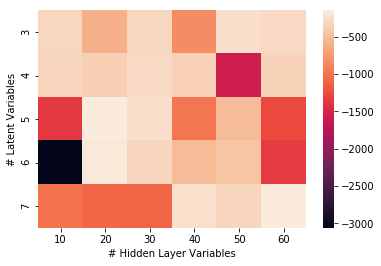

In [21]:
import seaborn as sns
sns.heatmap(-cv_results)
plt.xlabel('# Hidden Layer Variables')
plt.ylabel('# Latent Variables')
plt.show()

In [ ]:
X_model_input.shape

In [ ]:
# http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-fa-model-selection-py

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# #############################################################################
# Fit the models

n_components = np.arange(5, 60, 5)  # options for n_components

def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        if n % 1 == 0:
            print ("Running PCA/FA for {} Components...".format(n))
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X))) # Return the average log-likelihood of all samples.
        fa_scores.append(np.mean(cross_val_score(fa, X))) # Return the average log-likelihood of all samples.
    
    return pca_scores, fa_scores

def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))

def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))

print("Computing PCA and FA scores...")
pca_scores, fa_scores = compute_scores(X_model_input)
n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]

pca = PCA(svd_solver='full', n_components='mle')
pca.fit(X_model_input)
n_components_pca_mle = pca.n_components_

print("best n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
print("best n_components by PCA MLE = %d" % n_components_pca_mle)

In [ ]:
zip(n_components, pca_scores)

In [ ]:
zip(n_components, fa_scores)

In [ ]:
plt.figure()

#plt.plot(num_latent_vars[:6], -cv_results.loc[num_latent_vars[:6],150], 'g', label='VAE scores')

plt.plot(n_components, pca_scores, 'b', label='Probabilistic PCA scores')
# plt.axvline(n_components_pca, color='b',
#             label='PCA CV: %d' % n_components_pca, linestyle='--')

plt.plot(n_components, fa_scores, 'r', label='Factor Analysis scores')
# plt.axvline(n_components_fa, color='r',
#             label='FactorAnalysis CV: %d' % n_components_fa,
#             linestyle='--')

plt.axhline(lw_score(X), color='orange',
            label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

plt.xlabel('Number of Components')
plt.ylabel('Log-Likelihood')
# plt.ylabel('CV scores')
plt.legend(loc='lower right')

plt.show()